In [2]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from SSDC_Python.SSDC_Class import SSDC
from tqdm import tqdm



from scipy.spatial.distance import pdist, squareform
from SSDC_Python.makecons import MakeCons
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score, v_measure_score, adjusted_rand_score

In [38]:
def Unsat(labels, ml, cl):
  """Mide el número de restricciones insatisfechas respecto al total de restricciones.
  Devuelve:
  - La tasa de restricciones insatisfechas.
  - La tasa de restricciones insatisfechas de tipo must-link.
  - La tasa de restricciones insatisfechas de tipo cannot-link."""
  nml = len(ml)
  ncl = len(cl)
  ninsml = 0
  ninscl = 0
  for i in range(nml):
    if labels[ml[i][0]] == labels[ml[i][1]]:
      ninsml += 1
  for i in range(ncl):
    if labels[cl[i][0]] != labels[cl[i][1]]:
      ninscl += 1
  suma = nml + ncl - (ninsml+ninscl)
  result = suma/(nml+ncl)
  return result, (nml-ninsml)/nml, (ncl-ninscl)/ncl

In [68]:
def show_dim_reduction(X, y, title=""):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        tsne = TSNE(n_components=2)
        X_tsne = tsne.fit_transform(X)
        c = LabelEncoder().fit_transform(y)
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=c, s=30)
        axs[0].set_title("PCA. " + title)
        axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=c, s=30)
        axs[1].set_title("TSNE. " + title)
        plt.show()

In [40]:
def show_constraints(X, y, ml, cl, title=""):
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    c = LabelEncoder().fit_transform(y)
    plt.scatter(X[:, 0], X[:, 1], c=c, s=30, cmap='viridis')
    for i, j in ml:
        plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], c='g')
    for i, j in cl:
        plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], c='r')
    plt.title(title)
    plt.show()

In [41]:
X_iris, y_iris = datasets.load_iris(return_X_y=True)
X_wine, y_wine = datasets.load_wine(return_X_y=True)
df = pd.read_csv('datasets/ionosphere_data.csv')
X_iono, y_iono = df[df.columns[:-1]].values, df[df.columns[-1]].values
df = pd.read_csv('datasets/glass.csv')
X_glass, y_glass = df.iloc[:, :-1].values, df.iloc[:, -1].values
df = pd.read_csv('datasets/sonar.all-data.csv')
X_sonar, y_sonar = df.iloc[:, :-1].values, df.iloc[:, -1].values

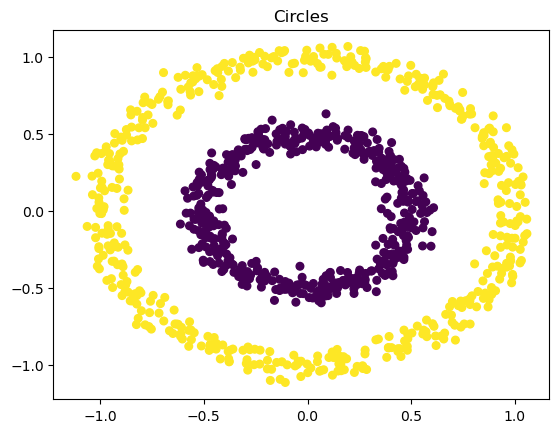

In [36]:
n_samples = 1000
seed = 42
X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
cl, ml = MakeCons(y, 0.03, seed=42)
SSDC_cust = SSDC()
SSDC_cust.fit(X, ml, cl)
labels = SSDC_cust.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis')
plt.title("Circles")
plt.show()


In [42]:
all_datasets = {"iris": [X_iris, y_iris], "wine": [X_wine, y_wine], "ionosphere": [X_iono, y_iono], "glass": [X_glass, y_glass], "sonar": [X_sonar, y_sonar]}
for i in all_datasets.keys():
    all_datasets[i][0] = StandardScaler().fit_transform(all_datasets[i][0])
all_constraints = dict()
metrics = {"davies_bouldin": davies_bouldin_score, "v_measure": v_measure_score, "Unsat": Unsat, "ARI":adjusted_rand_score, "Not_satisfied_ml":"", "Not_satisfied_cl":""}

In [43]:
import time
def run_clustering_experiment(param_grid, dataset, all_metrics):
    results = {}
    n_cons_var = 10
    init_seed = 30
    
    total_iterations = len(param_grid["D"]) * len(param_grid["percent"]) * len(param_grid["kernel"])
    pbar = tqdm(total=total_iterations, desc="Overall Progress")
    
    for D in param_grid["D"]:
        for percent in param_grid["percent"]:
            for kernel in param_grid["kernel"]:
                start_time = time.time()  # Iniciar el temporizador
                
                key = f"D={D}, percent={percent}, kernel={kernel}"
                results[key] = {
                    "Constraint_fraction": [],
                    "davies_bouldin": [],
                    "ARI": [],
                    "v_measure": [],
                    "Unsat": [],
                    "Not_satisfied_ml": [],
                    "Not_satisfied_cl": []
                }
                
                for N in param_grid["constraint_percent"]:
                    dav_boul_i = []
                    v_measure_i = []
                    unsat_i = []
                    not_satisfied_ml_i = []
                    not_satisfied_cl_i = []
                    ARI_i = []
                    for i in range(n_cons_var):
                        cl, ml = MakeCons(dataset[1], N, seed=init_seed+i)
                        SSDC_clust = SSDC(D, percent, kernel=kernel)
                        SSDC_clust.fit(dataset[0], ml, cl)
                        labels = SSDC_clust.labels_
                        dav_boul_i.append(all_metrics["davies_bouldin"](dataset[0], labels))
                        v_measure_i.append(all_metrics["v_measure"](dataset[1], labels))
                        unsat_i.append(all_metrics["Unsat"](labels, ml, cl)[0])
                        not_satisfied_ml_i.append(all_metrics["Unsat"](labels, ml, cl)[1])
                        not_satisfied_cl_i.append(all_metrics["Unsat"](labels, ml, cl)[2])
                        ARI_i.append(all_metrics["ARI"](dataset[1], labels))
                    results[key]["Constraint_fraction"].append(N)
                    results[key]["davies_bouldin"].append(np.mean(dav_boul_i))
                    results[key]["v_measure"].append(np.mean(v_measure_i))
                    results[key]["Unsat"].append(np.mean(unsat_i))
                    results[key]["Not_satisfied_ml"].append(np.mean(not_satisfied_ml_i))
                    results[key]["Not_satisfied_cl"].append(np.mean(not_satisfied_cl_i))
                    results[key]["ARI"].append(np.mean(ARI_i))
                
                # Actualizar la barra de progreso y mostrar el tiempo transcurrido
                elapsed_time = time.time() - start_time
                pbar.set_description(f"Completed: D={D}, %={percent}, Kernel={kernel} in {elapsed_time:.2f} sec")
                pbar.update(1)
    
    pbar.close()
    return results



In [44]:
param_grid = {"D": [1,2,5,10], "percent":[0.03,0.05,0.1,0.2,0.3,0.5,0.7,0.9], "kernel":["gaussian", "cutoff"], "constraint_percent":np.arange(0.005, 0.031, 0.005)}

results = run_clustering_experiment(param_grid, all_datasets["iris"], metrics)


Completed: D=10, %=0.9, Kernel=cutoff in 2.31 sec: 100%|██████████| 64/64 [02:06<00:00,  1.97s/it]   


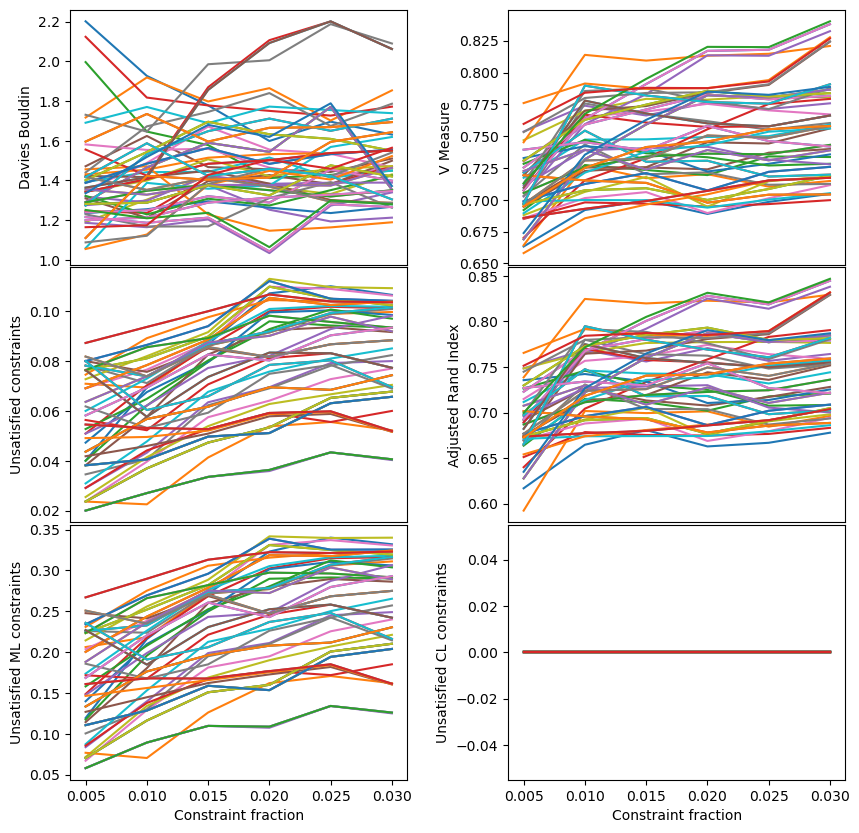

In [56]:
key_title = {"davies_bouldin": "Davies Bouldin", "v_measure": "V Measure", "Unsat": "Unsatisfied constraints", "ARI": "Adjusted Rand Index", "Not_satisfied_ml": "Unsatisfied ML constraints", "Not_satisfied_cl": "Unsatisfied CL constraints"}
plt.figure(figsize=(10, 10))
for i, configuration in enumerate(results.keys()):
    for j, metric in enumerate(metrics.keys()):
        plt.subplot(3, 2, j+1)
        plt.subplots_adjust(wspace=0.3, hspace = 0.01)
        plt.plot(results[configuration]["Constraint_fraction"], results[configuration][metric], label=configuration)
        plt.ylabel(key_title[metric])
        
        if j+1 >=5:
            plt.xlabel("Constraint fraction")
        else:
            plt.xticks([])
        # ax[j].legend()


In [59]:
def get_n_best_models(results, n, n_worst=False):
    best_models = {}
    for metric in results[list(results.keys())[0]].keys():
        if metric != "Constraint_fraction":
            best_models[metric] = []
            for key in results.keys():
                best_models[metric].append((key, np.round(np.mean(results[key][metric]),3)))
            best_models[metric] = sorted(best_models[metric], key=lambda x: x[1], reverse=metric in ["v_measure", "ARI"])
            if n_worst:
                best_models[metric] = best_models[metric][:n] + best_models[metric][::-1][:n]
            else:
                best_models[metric] = best_models[metric][:n]
    return best_models

def get_df_from_best_models(best_models):
    dfs = {}
    for metric in best_models.keys():
        dfs[metric] = pd.DataFrame(best_models[metric], columns=["Configuration", metric])
    return dfs

In [60]:
get_n_best_models(results, 5)
dfs = get_df_from_best_models(get_n_best_models(results, 5, True))
for metric in dfs.keys():
    print(dfs[metric])
    dfs[metric].to_csv(f"best_models_{metric}.csv", index=False)

                        Configuration  davies_bouldin
0   D=1, percent=0.9, kernel=gaussian           1.201
1   D=2, percent=0.9, kernel=gaussian           1.201
2   D=5, percent=0.9, kernel=gaussian           1.201
3  D=10, percent=0.9, kernel=gaussian           1.224
4     D=2, percent=0.5, kernel=cutoff           1.255
5     D=1, percent=0.2, kernel=cutoff           1.941
6     D=2, percent=0.2, kernel=cutoff           1.870
7    D=10, percent=0.2, kernel=cutoff           1.832
8     D=5, percent=0.2, kernel=cutoff           1.832
9    D=1, percent=0.05, kernel=cutoff           1.828
                        Configuration    ARI
0     D=1, percent=0.5, kernel=cutoff  0.809
1  D=10, percent=0.9, kernel=gaussian  0.796
2   D=2, percent=0.9, kernel=gaussian  0.792
3   D=5, percent=0.9, kernel=gaussian  0.792
4     D=2, percent=0.9, kernel=cutoff  0.791
5  D=1, percent=0.03, kernel=gaussian  0.662
6    D=1, percent=0.05, kernel=cutoff  0.673
7    D=2, percent=0.05, kernel=cutoff  0.677
8

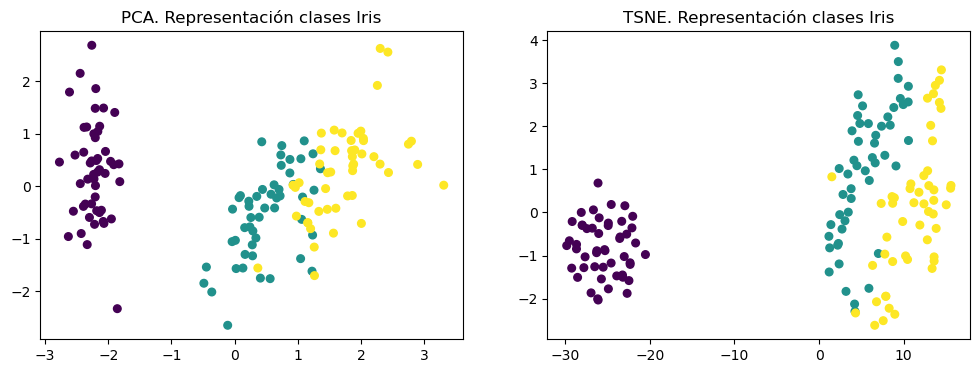

In [63]:
show_dim_reduction(all_datasets["iris"][0], all_datasets["iris"][1], title="Representación clases Iris")

In [64]:
D = [1,10,2]
P = [0.5,0.9,0.9]
kernel = ["cutoff", "gaussian", "gaussian"]
labels = []
for conf in range(3):
  SSDC_cust = SSDC(D[conf], P[conf], kernel=kernel[conf])
  cl, ml = MakeCons(all_datasets["iris"][1], 0.03, seed = 42)
  SSDC_cust.fit(all_datasets["iris"][0], ml, cl)
  labels.append(SSDC_cust.labels_)

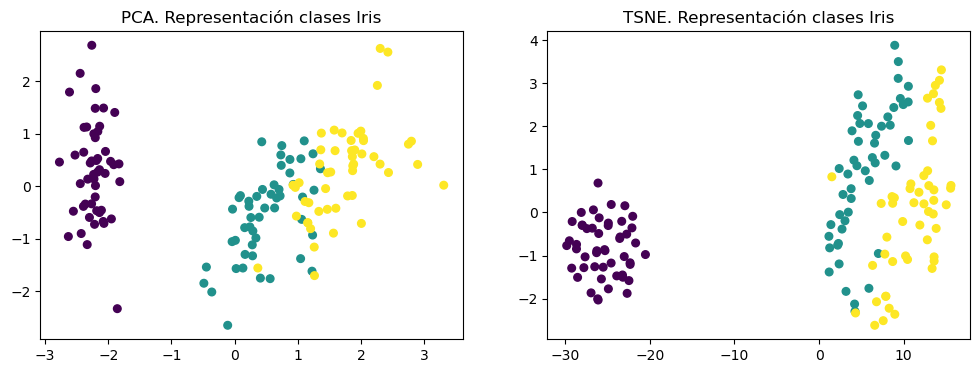

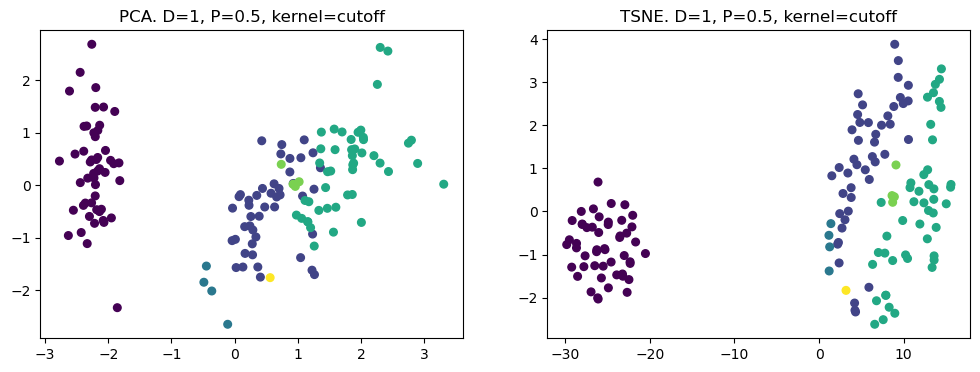

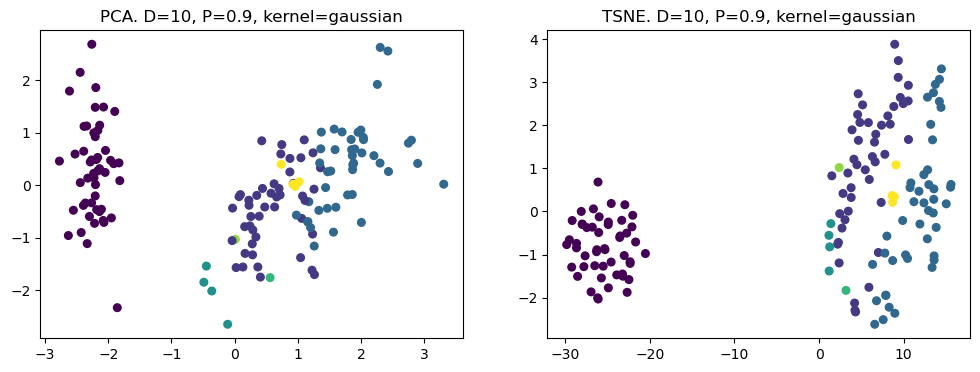

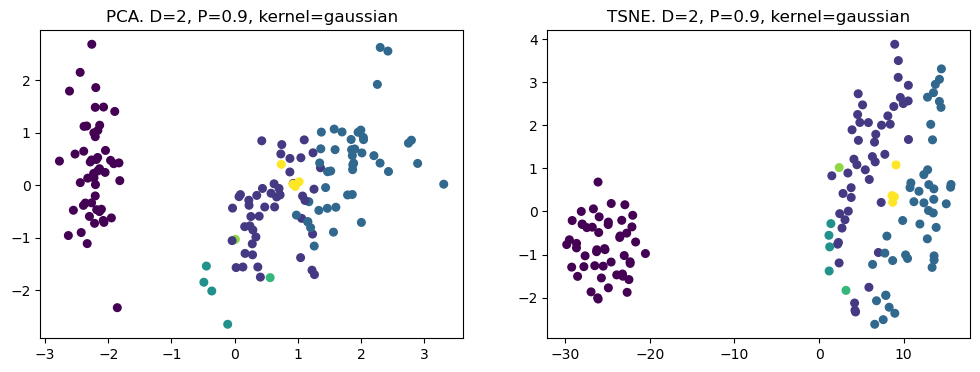

In [67]:
show_dim_reduction(all_datasets["iris"][0], all_datasets["iris"][1], title="Representación clases Iris")
for i in range(3):
  show_dim_reduction(all_datasets["iris"][0], labels[i], title=f"D={D[i]}, P={P[i]}, kernel={kernel[i]}")